# Main Visualization

This notebook produces the main visualization (Figure 3) of validation results, and computes p-values for results compared to the permutation tests. In order to run this, specify the folder name of the run you want to test, e.g. `1747831228_rf_outer3_cvrep5_k3_auc_testsize0.3_permFalse` as `folder`.

In [1]:
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
import ast
import scipy.stats as stats
import os

from matplotlib.legend_handler import HandlerBase
from statsmodels.stats.multitest import multipletests
from matplotlib.text import Text

In [2]:
class HandlerText(HandlerBase):
    def create_artists(self, legend, orig_handle, x0, y0, width, height, fontsize, trans):
        t = Text(x=x0, y=y0, text=orig_handle.get_text(), color='red', fontsize=fontsize)
        return [t]

In [3]:
folder = '1751555131_321_rf_outer100_cvrep5_k3_auc_testsize0.3_permFalse'
RES_DIR = os.path.join('../results', folder)

In [4]:
def plot_model_performance(res_dir):
    """
    Plots model performance comparing permutation vs non-permutation runs.
    
    Args:
        res_dir (str): Results directory for the run to visualize
    """

    perm_folder = os.path.join(res_dir, 'permutation_test', )

    perm_folder = os.path.join(res_dir, 'permutation_test')
    subfolders = [f for f in os.listdir(perm_folder) if os.path.isdir(os.path.join(perm_folder, f))]
    assert len(subfolders) == 1, "Expected exactly one subfolder"
    perm_folder = os.path.join(perm_folder, subfolders[0])


    test_scores_path = os.path.join(res_dir, "test_scores.csv")
    all_test_scores_nonperm_path = os.path.join(res_dir, "all_test_scores.csv")
    all_test_scores_perm_path = os.path.join(perm_folder, "all_test_scores.csv")

    # Existing plotting logic goes here, using the three files above

    df = pd.read_csv(test_scores_path)
    perm_df = pd.read_csv(all_test_scores_perm_path)
    all_test_df = pd.read_csv(all_test_scores_nonperm_path)

    perm_df["group"] = perm_df["group"].apply(ast.literal_eval)
    all_test_df["group"] = all_test_df["group"].apply(ast.literal_eval)

    factor_map = {
        "group_sub": "PEER", "alc_self": "ALC", "psych": "PSY",
        "group_socio": "SOC", "brain": "NR", "demo": "D"
    }

    df["Factor_Label"] = df.apply(
        lambda row: "-".join(sorted([factor_map.get(f, f) for f in [row["Factor_1"], row["Factor_2"]] if pd.notna(f)])),
        axis=1
    )
    print("Factor_Label values in df:", df["Factor_Label"].unique())

    factor_order = [
        "PSY-SOC", "NR-SOC", "NR-PSY",
        "ALC-NR", "ALC-SOC", "ALC-PSY", "ALC-D", "D-NR", "D-SOC", 
        "D-PSY", "NR-PEER", "PEER-SOC", 'PEER-PSY', "ALC-PEER", "D-PEER", "PEER", "NR", "SOC", "PSY", "ALC", "D"
    ]

    factor_order.reverse()

    df_filtered = df[df["Factor_Label"].isin(factor_order)].copy()
    df_filtered["Factor_Label"] = pd.Categorical(df_filtered["Factor_Label"], categories=factor_order, ordered=True)
    df_filtered = df_filtered.sort_values(by="Factor_Label", ascending=False)

    metrics = ["auc", "f1", "balancedAcc"]
    thresholds = {"auc": 0.7, "f1": 0.31, "balancedAcc": 0.5}

    results_list = []

    for _, row in df_filtered.iterrows():
        factor_tuple = tuple(sorted(filter(pd.notna, [row["Factor_1"], row["Factor_2"]])))
        perm_values = perm_df[perm_df["group"].apply(lambda x: tuple(sorted(x))) == factor_tuple]
        all_test_values = all_test_df[all_test_df["group"].apply(lambda x: tuple(sorted(x))) == factor_tuple]

        for metric in metrics:
            perm_metric_values = perm_values[metric]
            all_metric_values = all_test_values[metric]

            perm_p_value = (perm_metric_values >= row[f"{metric}_mean"]).sum() / len(perm_metric_values)
            t_stat, ttest_p_value = stats.ttest_ind(all_metric_values, perm_metric_values, equal_var=False)

            results_list.append({
                "Factor": row["Factor_Label"],
                "Metric": metric,
                "Permutation_p": perm_p_value,
                "TTest_p": ttest_p_value
            })

    results_df = pd.DataFrame(results_list)

    # === Within-domain multiple testing correction ===
    from statsmodels.stats.multitest import multipletests
    import numpy as np

    # Initialize columns
    results_df["Permutation_p_FDR_within"] = np.nan
    results_df["Permutation_sig_FDR_within"] = False
    results_df["TTest_p_FDR_within"] = np.nan
    results_df["TTest_sig_FDR_within"] = False

    for fac in results_df["Factor"].unique():
        mask = results_df["Factor"] == fac

        # Permutation p-values within this domain (across metrics)
        p_perm = results_df.loc[mask, "Permutation_p"].values
        if len(p_perm) > 1:  # apply only if there are multiple tests (e.g., 3 metrics)
            rej_perm, p_perm_fdr, _, _ = multipletests(p_perm, alpha=0.05, method="fdr_bh")
        else:
            rej_perm, p_perm_fdr = np.array([p_perm[0] < 0.05]), p_perm  # trivial case

        results_df.loc[mask, "Permutation_p_FDR_within"] = p_perm_fdr
        results_df.loc[mask, "Permutation_sig_FDR_within"] = rej_perm

        # T-test p-values within this domain (across metrics)
        p_t = results_df.loc[mask, "TTest_p"].values
        if len(p_t) > 1:
            rej_t, p_t_fdr, _, _ = multipletests(p_t, alpha=0.05, method="fdr_bh")
        else:
            rej_t, p_t_fdr = np.array([p_t[0] < 0.05]), p_t

        results_df.loc[mask, "TTest_p_FDR_within"] = p_t_fdr
        results_df.loc[mask, "TTest_sig_FDR_within"] = rej_t
    # ================================================================================


    # print(results_df)

    fig, axes = plt.subplots(1, 3, figsize=(15, 10), sharey=True)
    plot_settings = [("AUC (95% CI)", "auc"), ("F1 Score (95% CI)", "f1"), ("Balanced Accuracy (95% CI)", "balancedAcc")]
    fig.suptitle("SVM (linear) evaluation metrics for nested CV (k=3, j=5, i=100)", fontsize=20)
    fig.tight_layout(rect=[0, 0, 1, 1])
    # fig.supxlabel("Features Categories", x=0.01, y=0.5, fontsize=16, rotation=90)

    for ax, (title, metric) in zip(axes, plot_settings):
        ax.axvline(thresholds[metric], color="#4D194D", linestyle="--")

        for i, factor in enumerate(df_filtered["Factor_Label"]):
            mean = df_filtered[f"{metric}_mean"].iloc[i]
            lower = df_filtered[f"{metric}_CI_lower"].iloc[i]
            upper = df_filtered[f"{metric}_CI_upper"].iloc[i]
            transparency = 0.5 if lower < thresholds[metric] else 1.0

            # ax.scatter(mean, factor, color="#065A60", alpha=transparency, s=50)
            # ax.plot([lower, upper], [factor, factor], color="#065A60", alpha=transparency, linewidth=2.5)
            is_peer = "PEER" in factor
            color = "#4D194D" if is_peer else "#065A60"  # purple for PEER, green otherwise

            ax.scatter(mean, factor, color=color, alpha=transparency, s=50)
            ax.plot([lower, upper], [factor, factor], color=color, alpha=transparency, linewidth=2.5)

            perm_p = results_df[(results_df.Factor == factor) & (results_df.Metric == metric)].Permutation_p_FDR_within.values[0]
            if perm_p < 0.05:
                ax.text(mean + 0.005, factor, "*", color="red", fontsize=16, alpha=transparency)
            if perm_p < 0.01:
                ax.text(mean + 0.005, factor, "**", color="red", fontsize=16, alpha=transparency)

        ax.set_xlabel(title, fontsize=16)
        ax.tick_params(axis='both', labelsize=16)
        ax.grid(True)

    star1 = Text(0, 0, '*')
    star2 = Text(0, 0, '**')

    axes[2].legend([star1, star2],
                ['Permutation Test p < 0.05', 'Permutation Test p < 0.01'],
                handler_map={star1: HandlerText(), star2: HandlerText()},
                loc='upper right', fontsize=14)

    # Prepare PEER data for swarm+box plot
    grp_tuple = ("group_sub",)
    perm_grp = perm_df[perm_df["group"].apply(lambda x: tuple(sorted(x))) == grp_tuple].copy()
    all_grp = all_test_df[all_test_df["group"].apply(lambda x: tuple(sorted(x))) == grp_tuple].copy()

    perm_grp["type"] = "Permuted"
    all_grp["type"] = "Real"

    combined = pd.concat([perm_grp, all_grp], ignore_index=True)


    return results_df


Factor_Label values in df: ['D' 'ALC' 'PSY' 'PEER' 'SOC' 'NR' 'ALC-D' 'D-PSY' 'D-PEER' 'D-SOC' 'D-NR'
 'ALC-PSY' 'ALC-PEER' 'ALC-SOC' 'ALC-NR' 'PEER-PSY' 'PSY-SOC' 'NR-PSY'
 'PEER-SOC' 'NR-PEER' 'NR-SOC']


,Factor,Metric,Permutation_p,TTest_p,Permutation_p_FDR_within,Permutation_sig_FDR_within,TTest_p_FDR_within,TTest_sig_FDR_within
0,PSY-SOC,auc,0.66,2.841643e-04,0.74,False,4.262464e-04,True
1,PSY-SOC,f1,0.74,3.885981e-05,0.74,False,1.165794e-04,True
2,PSY-SOC,balancedAcc,0.66,1.249072e-03,0.74,False,1.249072e-03,True
3,NR-SOC,auc,0.49,8.312391e-01,0.49,False,8.312391e-01,False
4,NR-SOC,f1,0.48,6.472595e-01,0.49,False,8.312391e-01,False
...,...,...,...,...,...,...,...,...
58,ALC,f1,0.21,4.099372e-10,0.21,False,4.099372e-10,True
59,ALC,balancedAcc,0.16,3.802370e-11,0.21,False,5.703555e-11,True
60,D,auc,0.50,5.412985e-01,0.52,False,5.412985e-01,False
61,D,f1,0.52,2.979201e-01,0.52,False,5.412985e-01,False


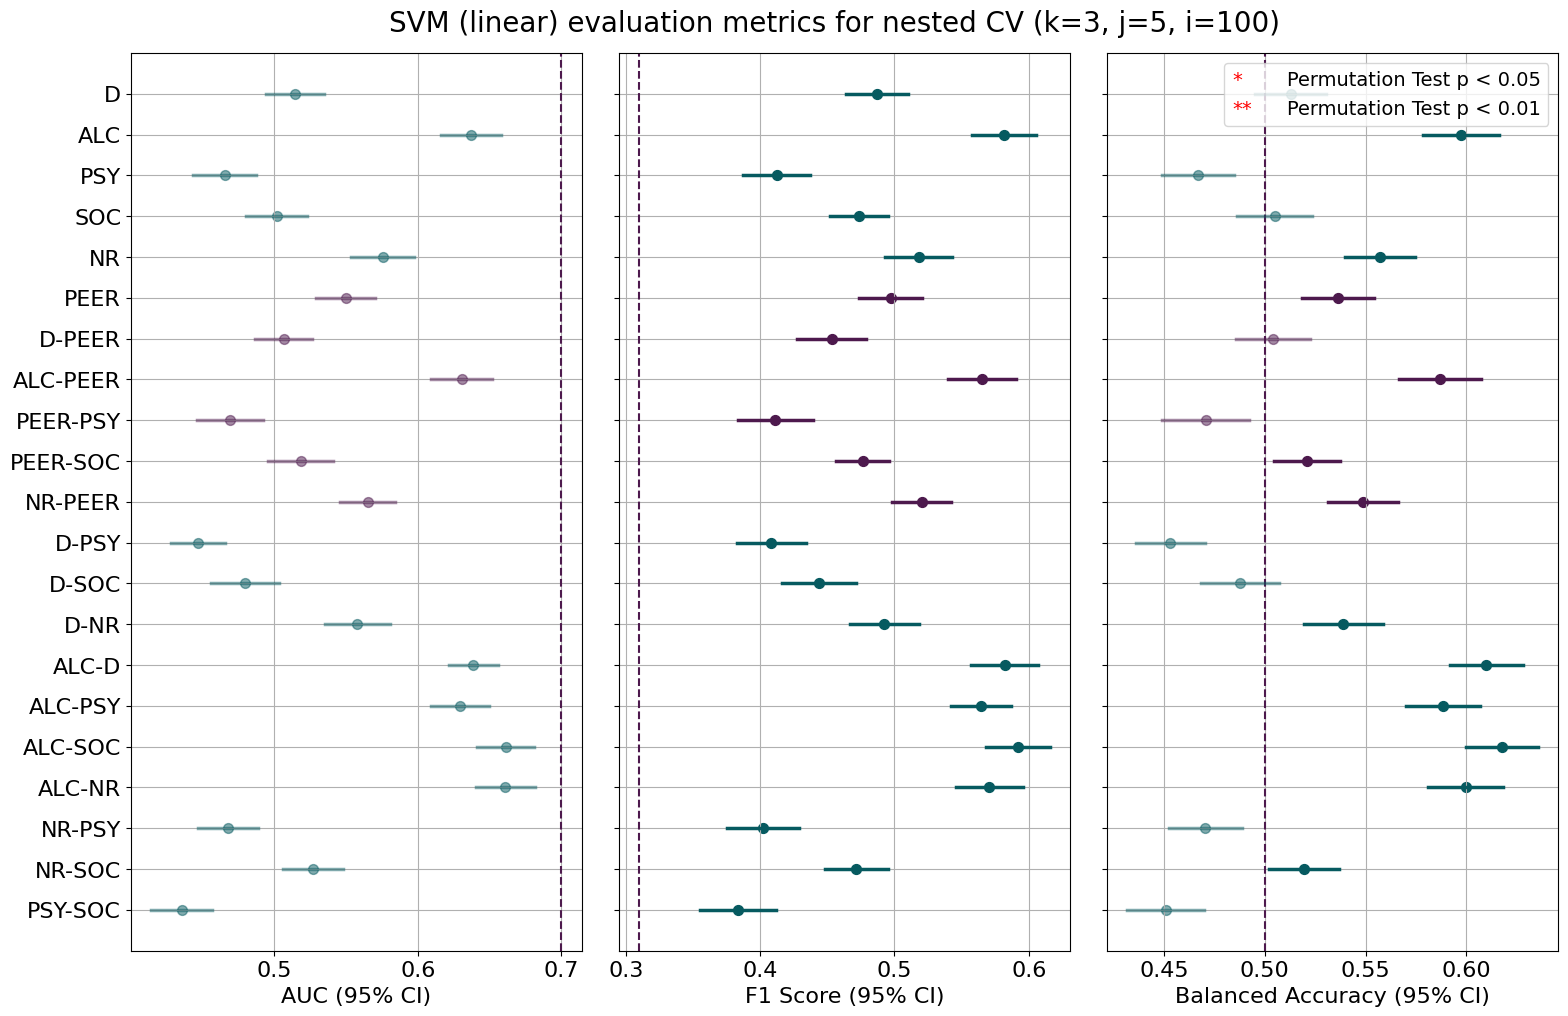

In [5]:
plot_model_performance(
    res_dir=RES_DIR
)

Save formatted final results table.

In [6]:
# Load original CSV
df = pd.read_csv(os.path.join(RES_DIR, "test_scores.csv")) 

# Calculate PPV + CIs before formatting
df["PPV_mean"] = df["tp_mean"] / (df["tp_mean"] + df["fp_mean"])
df["PPV_CI_lower"] = df["tp_CI_lower"] / (df["tp_CI_lower"] + df["fp_CI_upper"])
df["PPV_CI_upper"] = df["tp_CI_upper"] / (df["tp_CI_upper"] + df["fp_CI_lower"])


# Metrics to include and format
selected_metrics = ["auc", "f1", "balancedAcc", "sensitivity", "specificity", "pr_auc", "PPV", "NPV"]

# Build formatted output
output_rows = []

for _, row in df.iterrows():
    row_dict = {}

    # Combine Factor_1 and Factor_2 into "Feature Category"
    factor_1 = row['Factor_1']
    factor_2 = row['Factor_2']
    if pd.isna(factor_2) or str(factor_2).strip() == "":
        row_dict["Feature Category"] = str(factor_1)
    else:
        row_dict["Feature Category"] = f"{factor_1}-{factor_2}"

    # Format selected metrics with newline and 3 decimal precision
    for metric in selected_metrics:
        mean = f"{row[f'{metric}_mean']:.3f}"
        ci_low = f"{row[f'{metric}_CI_lower']:.3f}"
        ci_up = f"{row[f'{metric}_CI_upper']:.3f}"
        row_dict[metric.upper()] = f"{mean}\n({ci_low}–{ci_up})"

    output_rows.append(row_dict)

# Create and save the final DataFrame
df_out = pd.DataFrame(output_rows)

# Save to new CSV
df_out.to_csv(os.path.join(RES_DIR, "formatted_metrics_table.csv"), index=False)


# Actual vs Perceived Peer Drinking

In [7]:
true_vs_perceived = pd.read_csv('../data/added_analysis/peer_perceptions_vs_peer_selfreports.csv')

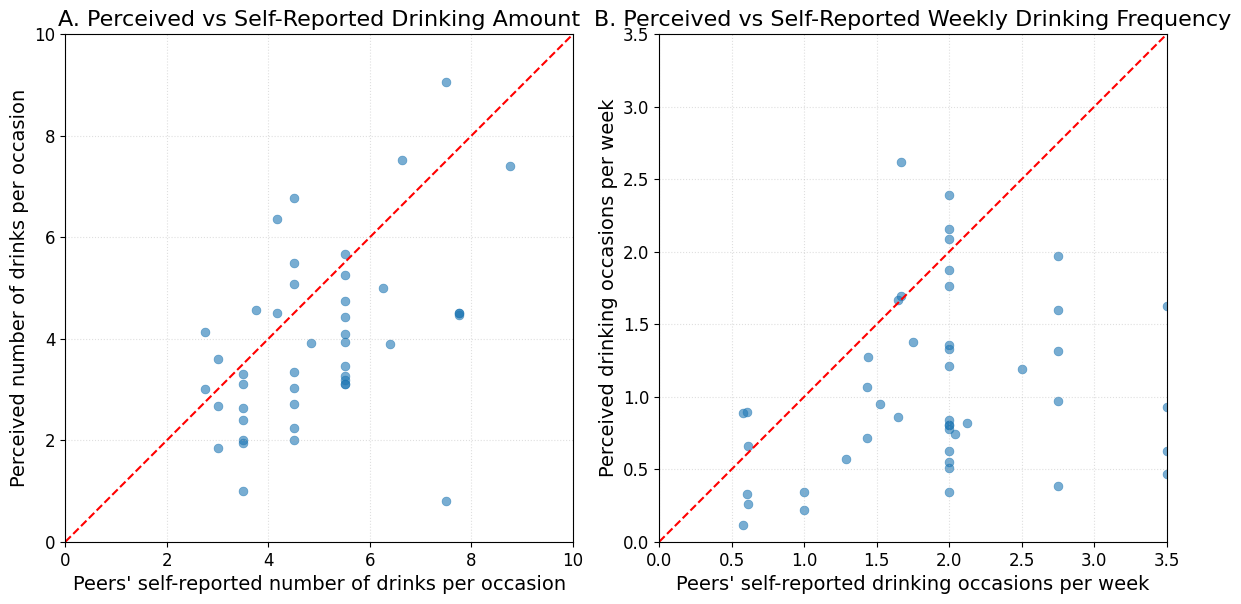

In [8]:
df = true_vs_perceived
cols = ["avg_amount_friends_true", "avg_alcmost_amount",
        "avg_freq_friends_true", "avg_alcmost_freq"]
for c in cols:
    df[c] = pd.to_numeric(df[c], errors="coerce")
df = df.dropna(subset=cols)

# Convert yearly frequency to weekly on the copy only
df["avg_freq_true_week"] = df["avg_freq_friends_true"] / 52.0
df["avg_freq_perc_week"] = df["avg_alcmost_freq"] / 52.0

# Figure
fig, axes = plt.subplots(1, 2, figsize=(12, 6))

label_fs, title_fs, tick_fs = 14, 16, 12

# Panel A: Amount per occasion
sns.scatterplot(
    data=df, x="avg_amount_friends_true", y="avg_alcmost_amount",
    ax=axes[0], s=40, alpha=0.6, edgecolor=None
)
# Set symmetric limits so 1:1 line is meaningful
max_a = np.nanmax(df[["avg_amount_friends_true","avg_alcmost_amount"]].values)
max_a = max(1.0, min(max_a, 10.0))  # cap at 10 if you want the plot bounded
axes[0].plot([0, max_a], [0, max_a], color="red", linestyle="--", linewidth=1.5)
axes[0].set_xlim(0, max_a); axes[0].set_ylim(0, max_a)
axes[0].set_aspect('equal', adjustable='box')
axes[0].set_xlabel("Peers' self-reported number of drinks per occasion", fontsize=label_fs)
axes[0].set_ylabel("Perceived number of drinks per occasion", fontsize=label_fs)
axes[0].set_title("A. Perceived vs Self-Reported Drinking Amount", fontsize=title_fs)
axes[0].grid(True, linestyle=":", alpha=0.4)
axes[0].tick_params(axis='both', labelsize=tick_fs)

# Panel B: Weekly frequency
sns.scatterplot(
    data=df, x="avg_freq_true_week", y="avg_freq_perc_week",
    ax=axes[1], s=40, alpha=0.6, edgecolor=None
)
max_f = np.nanmax(df[["avg_freq_true_week","avg_freq_perc_week"]].values)
# reasonable upper bound for weekly occasions
max_f = max(0.5, min(max_f, 7.0))
axes[1].plot([0, max_f], [0, max_f], color="red", linestyle="--", linewidth=1.5)
axes[1].set_xlim(0, max_f); axes[1].set_ylim(0, max_f)
axes[1].set_aspect('equal', adjustable='box')
axes[1].set_xlabel("Peers' self-reported drinking occasions per week", fontsize=label_fs)
axes[1].set_ylabel("Perceived drinking occasions per week", fontsize=label_fs)
axes[1].set_title("B. Perceived vs Self-Reported Weekly Drinking Frequency", fontsize=title_fs)
axes[1].grid(True, linestyle=":", alpha=0.4)
axes[1].tick_params(axis='both', labelsize=tick_fs)

plt.tight_layout()
plt.show()


In [9]:
def plot_model_performance_comparison(res_dir_rf, res_dir_lr):
    """
    Plots model performance comparing Random Forest vs Logistic Regression
    across AUC, F1, and Balanced Accuracy, including permutation significance markers,
    clean CI lines (no caps), shaded PEER-related categories, and legend with red asterisks.
    """
    import os, ast
    import pandas as pd
    import numpy as np
    import matplotlib.pyplot as plt
    from matplotlib.lines import Line2D
    from scipy import stats
    from statsmodels.stats.multitest import multipletests

    def load_data(res_dir):
        perm_folder = os.path.join(res_dir, 'permutation_test')
        subfolders = [f for f in os.listdir(perm_folder) if os.path.isdir(os.path.join(perm_folder, f))]
        assert len(subfolders) == 1, f"Expected exactly one subfolder in {perm_folder}"
        perm_folder = os.path.join(perm_folder, subfolders[0])

        df = pd.read_csv(os.path.join(res_dir, "test_scores.csv"))
        perm_df = pd.read_csv(os.path.join(perm_folder, "all_test_scores.csv"))
        all_test_df = pd.read_csv(os.path.join(res_dir, "all_test_scores.csv"))

        perm_df["group"] = perm_df["group"].apply(ast.literal_eval)
        all_test_df["group"] = all_test_df["group"].apply(ast.literal_eval)

        factor_map = {
            "group_sub": "PEER", "alc_self": "ALC", "psych": "PSY",
            "group_socio": "SOC", "brain": "NR", "demo": "D"
        }
        df["Factor_Label"] = df.apply(
            lambda row: "-".join(sorted([factor_map.get(f, f) for f in [row["Factor_1"], row["Factor_2"]] if pd.notna(f)])),
            axis=1
        )
        return df, perm_df, all_test_df

    # === Load both models ===
    df_rf, perm_df_rf, all_test_df_rf = load_data(res_dir_rf)
    df_lr, perm_df_lr, all_test_df_lr = load_data(res_dir_lr)

    factor_order = [
        "PSY-SOC", "NR-SOC", "NR-PSY", "ALC-NR", "ALC-SOC", "ALC-PSY",
        "ALC-D", "D-NR", "D-SOC", "D-PSY", "NR-PEER", "PEER-SOC", "PEER-PSY",
        "ALC-PEER", "D-PEER", "PEER", "NR", "SOC", "PSY", "ALC", "D"
    ][::-1]

    def prepare_df(df):
        df = df[df["Factor_Label"].isin(factor_order)].copy()
        df["Factor_Label"] = pd.Categorical(df["Factor_Label"], categories=factor_order, ordered=True)
        df = df.sort_values(by="Factor_Label", ascending=False)
        return df

    df_rf = prepare_df(df_rf)
    df_lr = prepare_df(df_lr)

    metrics = ["auc", "f1", "balancedAcc"]
    thresholds = {"auc": 0.7, "f1": 0.31, "balancedAcc": 0.5}

    def compute_significance(df_main, perm_df, all_test_df):
        results_list = []
        for _, row in df_main.iterrows():
            factor_tuple = tuple(sorted(filter(pd.notna, [row["Factor_1"], row["Factor_2"]])))
            perm_values = perm_df[perm_df["group"].apply(lambda x: tuple(sorted(x))) == factor_tuple]
            for metric in metrics:
                perm_metric_values = perm_values[metric]
                perm_p_value = (perm_metric_values >= row[f"{metric}_mean"]).sum() / len(perm_metric_values)
                results_list.append({
                    "Factor": row["Factor_Label"],
                    "Metric": metric,
                    "Permutation_p": perm_p_value
                })
        results_df = pd.DataFrame(results_list)
        results_df["Permutation_p_FDR_within"] = np.nan
        results_df["Permutation_sig_FDR_within"] = False
        for fac in results_df["Factor"].unique():
            mask = results_df["Factor"] == fac
            p_vals = results_df.loc[mask, "Permutation_p"].values
            if len(p_vals) > 1:
                rej, p_fdr, _, _ = multipletests(p_vals, alpha=0.05, method="fdr_bh")
            else:
                rej, p_fdr = np.array([p_vals[0] < 0.05]), p_vals
            results_df.loc[mask, "Permutation_p_FDR_within"] = p_fdr
            results_df.loc[mask, "Permutation_sig_FDR_within"] = rej
        return results_df

    sig_rf = compute_significance(df_rf, perm_df_rf, all_test_df_rf)
    sig_lr = compute_significance(df_lr, perm_df_lr, all_test_df_lr)

    # === Plotting ===
    fig, axes = plt.subplots(1, 3, figsize=(15, 10), sharey=True)
    plot_settings = [("AUC (95% CI)", "auc"), ("F1 Score (95% CI)", "f1"), ("Balanced Accuracy (95% CI)", "balancedAcc")]
    fig.suptitle("Random forest and logistic regression evaluation metrics for nested CV (k=3, j=5, i=100)", fontsize=20)
    fig.tight_layout(rect=[0, 0, 1, 1])

    colors = {"RF": "#065A60", "LR": "#C08497"}

    # Identify indices for PEER-related rows
    peer_indices = [i for i, f in enumerate(df_rf["Factor_Label"]) if "PEER" in f]

    for ax, (title, metric) in zip(axes, plot_settings):
        ax.axvline(thresholds[metric], color="gray", linestyle="--", alpha=0.6)

        # Shade PEER-related rows
        for idx in peer_indices:
            ax.axhspan(idx - 0.5, idx + 0.5, color="#BFD9DA", alpha=0.4, zorder=0)

        for model_label, df_model, sig_df, color in [
            ("RF", df_rf, sig_rf, colors["RF"]),
            ("LR", df_lr, sig_lr, colors["LR"])
        ]:
            offset = -0.2 if model_label == "RF" else 0.2
            for i, factor in enumerate(df_model["Factor_Label"]):
                mean = df_model[f"{metric}_mean"].iloc[i]
                lower = df_model[f"{metric}_CI_lower"].iloc[i]
                upper = df_model[f"{metric}_CI_upper"].iloc[i]
                transparency = 0.5 if lower < thresholds[metric] else 1.0

                # Clean CI lines (no caps)
                ax.errorbar(mean, i + offset, xerr=[[mean - lower], [upper - mean]], fmt='o',
                            color=color, alpha=transparency, label=model_label if i == 0 else "",
                            capsize=0, elinewidth=2.5, solid_capstyle='butt', markersize=6)

                # Significance markers
                perm_p = sig_df[(sig_df.Factor == factor) & (sig_df.Metric == metric)].Permutation_p_FDR_within.values[0]
                if perm_p < 0.01:
                    ax.text(mean + 0.005, i + offset - 0.1, "**", color="red", fontsize=14, alpha=transparency)
                elif perm_p < 0.05:
                    ax.text(mean + 0.005, i + offset - 0.1, "*", color="red", fontsize=14, alpha=transparency)

        ax.set_xlabel(title, fontsize=16)
        ax.set_yticks(range(len(df_rf["Factor_Label"])))
        ax.set_yticklabels(df_rf["Factor_Label"], fontsize=14)
        ax.tick_params(axis='x', labelsize=14)
        ax.grid(True, linestyle=":", alpha=0.5, zorder=1)

    # === Legend ===
    handles_model = [
        Line2D([0], [0], color=colors["RF"], marker='o', linestyle='', label='Random Forest'),
        Line2D([0], [0], color=colors["LR"], marker='o', linestyle='', label='Logistic Regression')
    ]
    handles_sig = [
        Line2D([0], [0], color='red', marker='', linestyle='', label='*  p < 0.05'),
        Line2D([0], [0], color='red', marker='', linestyle='', label='** p < 0.01')
    ]

    axes[2].legend(handles=handles_model + handles_sig, loc='upper right', fontsize=14, frameon=True)

    plt.tight_layout()
    plt.show()


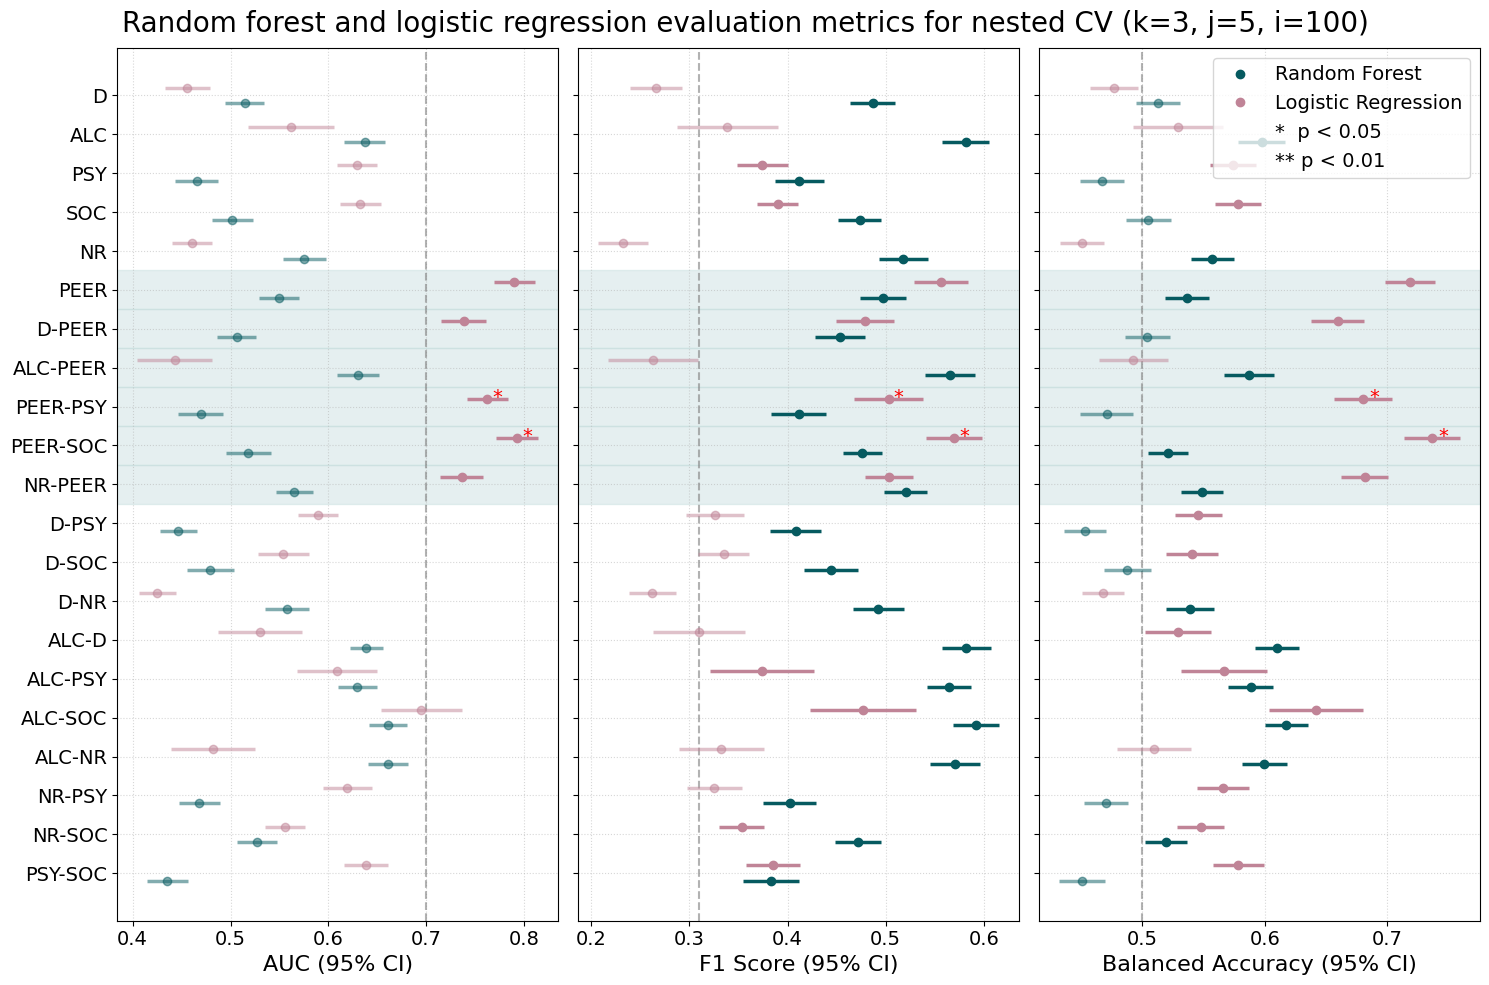

In [10]:
plot_model_performance_comparison("../results/1751555131_321_rf_outer100_cvrep5_k3_auc_testsize0.3_permFalse", "../results_logreg/1760898281_321_lr_elasticnet_outer100_cvrep5_k3_auc_testsize0.3_permFalse")